<a href="https://colab.research.google.com/github/abksyed/EVA4/blob/master/S5/EVA4B2_S5_Assignment_Iter01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 16, 3, padding= 1)  #Out - 28
        #F.relu()
        self.batch1 = nn.BatchNorm2d(16)
        self.drop1 = nn.Dropout2d(0.1)

        self.conv2 = nn.Conv2d(16, 32, 3, padding= 1) #Out - 28
        #F.relu()
        self.batch2 = nn.BatchNorm2d(32)
        self.drop2 = nn.Dropout2d(0.1)

        self.pool1 = nn.MaxPool2d(2, 2) #Out - 14
        self.conv_11 = nn.Conv2d(32, 8, 1) #Out - 14
        #self.batch_11 = nn.BatchNorm2d(8)
        #self.drop_11 = nn.Dropout2d(0.1)

        self.conv3 = nn.Conv2d(8, 16, 3, padding= 1) #Out - 14
        #F.relu()
        self.batch3 = nn.BatchNorm2d(16)
        self.drop3 = nn.Dropout2d(0.1)

        self.conv4 = nn.Conv2d(16, 32, 3, padding= 1) #Out - 14
        #F.relu()
        self.batch4 = nn.BatchNorm2d(32)
        self.drop4 = nn.Dropout2d(0.1)

        self.pool2 = nn.MaxPool2d(2, 2) #Out - 7
        self.conv_12 = nn.Conv2d(32, 16, 1) #Out - 7
        #self.batch_12 = nn.BatchNorm2d(16)
        #self.drop_12 = nn.Dropout2d(0.1)


        self.conv5 = nn.Conv2d(16, 32, 3) #Out - 5
        #F.relu()
        self.batch5 = nn.BatchNorm2d(32)
        self.drop5 = nn.Dropout2d(0.1)

        self.conv6 = nn.Conv2d(32, 10, 3) #Out - 3
        self.gap = nn.AvgPool2d(3) #Out - 1

        #self.conv7 = nn.Conv2d(32, 10, 3) #Out - 1      

    def forward(self, x):
        x = self.conv_11(self.pool1(self.drop2(self.batch2(F.relu(self.conv2(self.drop1(self.batch1(F.relu(self.conv1(x))))))))))
        x = self.conv_12(self.pool2(self.drop4(self.batch4(F.relu(self.conv4(self.drop3(self.batch3(F.relu(self.conv3(x))))))))))
        x = self.gap(self.conv6(self.drop5(F.relu(self.conv5(x)))))
        #x = self.conv7(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
         Dropout2d-3           [-1, 16, 28, 28]               0
            Conv2d-4           [-1, 32, 28, 28]           4,640
       BatchNorm2d-5           [-1, 32, 28, 28]              64
         Dropout2d-6           [-1, 32, 28, 28]               0
         MaxPool2d-7           [-1, 32, 14, 14]               0
            Conv2d-8            [-1, 8, 14, 14]             264
            Conv2d-9           [-1, 16, 14, 14]           1,168
      BatchNorm2d-10           [-1, 16, 14, 14]              32
        Dropout2d-11           [-1, 16, 14, 14]               0
           Conv2d-12           [-1, 32, 14, 14]           4,640
      BatchNorm2d-13           [-1, 32, 14, 14]              64
        Dropout2d-14           [-1, 32,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
torch.manual_seed(1)
batch_size = 64

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


In [0]:
acc = []
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    acc.append(100. * correct / len(test_loader.dataset))

In [0]:

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 21):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0613, Accuracy: 9775/10000 (97.75%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0426, Accuracy: 9852/10000 (98.52%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9905/10000 (99.05%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9922/10000 (99.22%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 9914/10000 (99.14%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9918/10000 (99.18%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9926/10000 (99.26%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9924/10000 (99.24%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9924/10000 (99.24%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9941/10000 (99.41%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9934/10000 (99.34%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9939/10000 (99.39%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9947/10000 (99.47%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 9951/10000 (99.51%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9945/10000 (99.45%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0159, Accuracy: 9950/10000 (99.50%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9955/10000 (99.55%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9944/10000 (99.44%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9948/10000 (99.48%)



loss=0.0003122687339782715 batch_id=937: 100%|██████████| 938/938 [00:14<00:00, 66.00it/s]



Test set: Average loss: 0.0168, Accuracy: 9952/10000 (99.52%)



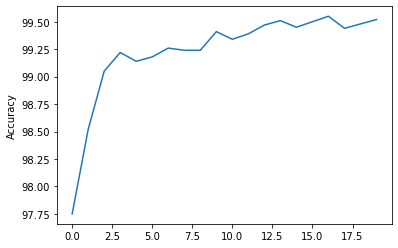

99.55


In [0]:
import matplotlib.pyplot as plt
plt.plot(acc)
plt.ylabel('Accuracy')
plt.show()

print(max(acc))

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

In [0]:
#model_save_name = 'S4 99-44 model.pt'
#path = F"/content/drive/My Drive/EVA 4/{model_save_name}" 
#torch.save(model.state_dict(), path)